## K-Nearest Neighbors Classification
### Income Prediction Using Distance-Based Learning

#### **Overview**

The k-Nearest Neighbors (k-NN) algorithm is a **non-parametric, instance-based learning method** that classifies observations based on the labels of nearby points in feature space. Rather than learning explicit model parameters, k-NN relies on a distance metric to determine similarity between observations.

This notebook demonstrates the application of a **custom NumPy-based k-NN classifier** (implemented in rice_ml) to the **Income Dataset**, a demographic dataset containing both numeric and categorical features. Because k-NN relies on distance computations, this example highlights the importance of **feature scaling, encoding strategies, and distance metric selection.**

The goals of this notebook are to:

- Explore the structure of the Income Dataset

- Motivate preprocessing decisions for distance-based models

- Apply a reusable k-NN classifier implemented from scratch

- Evaluate classification performance under different hyperparameters

#### **1. Imports and Project Setup**

In [6]:
# ------------------------
# Load libraries
# ------------------------
import pandas as pd
import numpy as np
from pathlib import Path
import sys
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# ------------------------
# Setup repo and src path
# ------------------------

# --- Custom Imports from rice_ml ---
# Note: These imports assume your custom files are correctly structured 
# (e.g., rice_ml/processing/preprocessing.py, etc.)

# Processing Utilities
from rice_ml.processing.preprocessing import (
    train_test_split, 
    standardize,
)
# Metrics
from rice_ml.processing.post_processing import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    confusion_matrix,
)

# Custom Model Imports
from rice_ml.supervised_learning.ensemble_methods import (
    RandomForestClassifier, 
    VotingClassifier
)
from rice_ml.supervised_learning.decision_trees import DecisionTreeClassifier

# Set up the path to access the custom source code
repo_root = Path().resolve().parents[2] # Adjust this path as necessary for your local structure
# Fallback for notebook environment pathing (adjust if needed)
if 'CMOR_438_Final_Repository' not in str(repo_root):
     repo_root = Path.cwd().parents[1] 

src_path = repo_root / "src"
# Ensure the src path is in the system path for imports to work
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

#### **2. Dataset Description**

**File:** Income_Dataset.csv

The Income Dataset provides demographic and socioeconomic information for a large set of individuals. Each observation includes features such as age, education, gender, marital status, occupation, work hours, and capital gains or losses. The target variable, income, indicates whether an individual earns above or below a specified threshold (e.g., $50K annually).

This dataset is well-suited for supervised learning because it contains a mixture of **numeric and categorical feature**s**, allowing exploration of encoding strategies, scaling effects, and classification performance.

**Key Variables**

- age: Age of the individual

- education, educational-num: Education level (categorical and numeric)

- hours-per-week: Weekly working hours

- capital-gain, capital-loss: Investment-related income

- workclass, occupation, marital-status: Employment-related categories

- income: Target variable (binary)

#### **3. Load and Inspect the Dataset**

In [7]:
# ------------------------
# Load dataset
# ------------------------
# Build path to dataset
data_path = repo_root / "Data/adult.csv" # Assuming 'adult.csv' is in your Data folder

# Check for file existence before proceeding
if not data_path.exists():
    raise FileNotFoundError(f"Dataset not found at expected path: {data_path}. Please update the 'data_path' variable.")

# Load dataset
df = pd.read_csv(data_path)

# Quick inspection
display(df.head())
print(f"Dataset shape: {df.shape}")
print("\nIncome distribution:")
print(df["income"].value_counts())
print("\nDataset info:")
df.info()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


Dataset shape: (48842, 15)

Income distribution:
income
<=50K    37155
>50K     11687
Name: count, dtype: int64

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        48842 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       48842 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   48842 non-null  object
 14  income           48842 non-null  object

##### 3.1 Handling Missing Values

In [8]:
# We replace the '?' convention for missing values with `np.nan` and then drop rows containing any missing values.

df = df.replace("?", np.nan)
df = df.dropna()
print(f"Dataset shape after dropping NaNs: {df.shape}")

Dataset shape after dropping NaNs: (45222, 15)


#### **4. Exploratory Data Analysis (EDA)**

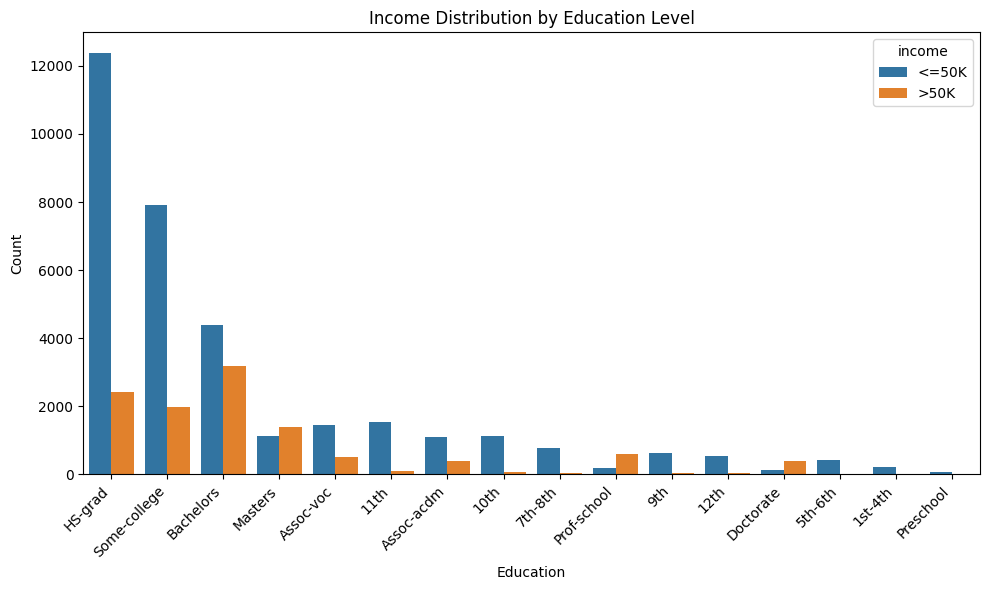

In [11]:
plt.figure(figsize=(10, 6))
sns.countplot(
    data=df,
    x="education",
    hue="income",
    order=df["education"].value_counts().index
)
plt.title("Income Distribution by Education Level")
plt.xlabel("Education")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

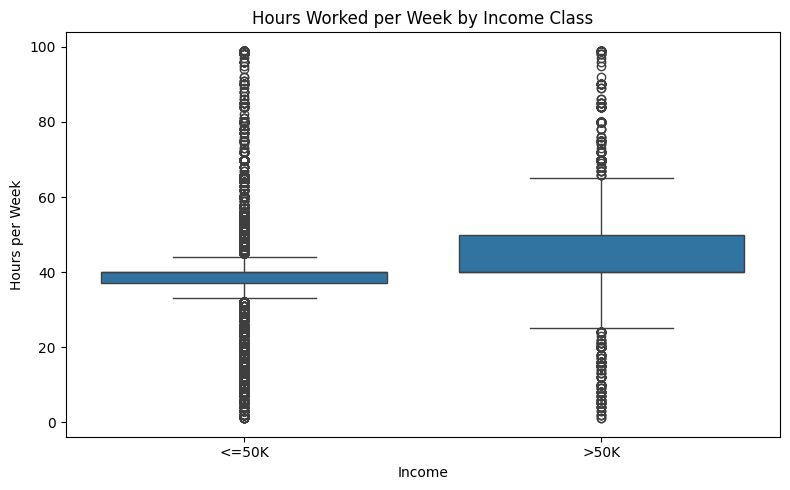

In [12]:
# --- Income vs. Hours Worked ---
plt.figure(figsize=(8, 5))
sns.boxplot(
    data=df,
    x="income",
    y="hours-per-week"
)
plt.title("Hours Worked per Week by Income Class")
plt.xlabel("Income")
plt.ylabel("Hours per Week")
plt.tight_layout()
plt.show()

#### **5. Preprocessing and Feature Engineering**

##### 5.1 Encode categorical variables

In [15]:
df_proc = df.copy()

# Target Encoding: '<=50K' -> 0, '>50K' -> 1
y_labels = df_proc['income'].apply(lambda x: 0 if x == "<=50K" else 1).values

# Feature Encoding: One-hot encode categorical features
X_raw = df_proc.drop(columns=['income'])
X_encoded = pd.get_dummies(X_raw, drop_first=True)
feature_names = X_encoded.columns.tolist() # Keep feature names for importance plot
X_data = X_encoded.values # Convert to NumPy array

##### 5.2 Standardize 

In [16]:
# Feature Scaling (Standardization)
# Use the custom standardize function
X_scaled, scale_params = standardize(X_data, return_params=True)

##### 5.3 Train-Test Split (80/20)

In [17]:
# Train-Test Split (using custom train_test_split)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, 
    y_labels, 
    test_size=0.2, 
    random_state=42, 
    shuffle=True, 
    stratify=y_labels
)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (36177, 96), y_train shape: (36177,)
X_test shape: (9045, 96), y_test shape: (9045,)


#### **6. Training the Random Forest Classifier**

In [23]:
# Initialize and Train Custom Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=15, 
    max_features= 5,
    random_state=42
)
print("Fitting custom Random Forest...")
rf_model.fit(X_train, y_train)
print("Fitting complete.")

# Predictions and Evaluation
y_pred_rf = rf_model.predict(X_test)

acc_rf = accuracy_score(y_test, y_pred_rf)
prec_rf = precision_score(y_test, y_pred_rf, average="binary")
rec_rf = recall_score(y_test, y_pred_rf, average="binary")
f1_rf = f1_score(y_test, y_pred_rf, average="binary")

print(f"\n--- Random Forest Results ---")
print(f"Test Accuracy: {acc_rf:.4f}")
print(f"Precision (Class 1): {prec_rf:.4f}")
print(f"Recall (Class 1): {rec_rf:.4f}")
print(f"F1 Score (Class 1): {f1_rf:.4f}")

# Confusion matrix visualization
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6,4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=['<=50K', '>50K'],
            yticklabels=['<=50K', '>50K'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Custom Random Forest Confusion Matrix')
plt.show()

# Feature Importance Visualization
feat_imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': rf_model.feature_importances_
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(
    x='importance',
    y='feature',
    data=feat_imp_df.head(15),
    color='darkgreen'
)
plt.title("Top 15 Feature Importances - Custom Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

Fitting custom Random Forest...


TypeError: max_features must be 'sqrt', 'log2', or a float in (0.0, 1.0].

In [19]:
# --- DEBUG: Test Single Decision Tree ---

# Initialize a deep Decision Tree to ensure it can find splits
debug_dt = DecisionTreeClassifier(
    max_depth=20, 
    min_samples_split=5, 
    criterion='gini',
    random_state=42
)

print("Fitting debug Decision Tree...")
debug_dt.fit(X_train, y_train)
y_pred_debug = debug_dt.predict(X_test)

acc_debug = accuracy_score(y_test, y_pred_debug)
rec_debug = recall_score(y_test, y_pred_debug, average="binary")
prec_debug = precision_score(y_test, y_pred_debug, average="binary")

print("\n--- DEBUG Decision Tree Results ---")
print(f"Test Accuracy: {acc_debug:.4f}")
print(f"Recall (Class 1): {rec_debug:.4f}")
print(f"Precision (Class 1): {prec_debug:.4f}")

# --- END DEBUG ---

Fitting debug Decision Tree...

--- DEBUG Decision Tree Results ---
Test Accuracy: 0.8376
Recall (Class 1): 0.6186
Precision (Class 1): 0.6932


#### **7. Custom Voting Ensemble Classifier (Decision Tree Ensemble)**

In [ ]:
# 7.1 Initialize Base Models
dt_base = DecisionTreeClassifier(max_depth=7, criterion='entropy', random_state=42)
# Re-use the already trained, strong RF model or train a simpler one
rf_base = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42)

# 7.2 Hard Voting Classifier (majority class)
hard_voting_clf = VotingClassifier(
    estimators=[('dt', dt_base), ('rf', rf_base)],
    voting='hard'
)

print("Fitting Hard Voting Ensemble (DT + RF)...")
hard_voting_clf.fit(X_train, y_train)
y_pred_hard = hard_voting_clf.predict(X_test)
print("Fitting complete.")

acc_hard = accuracy_score(y_test, y_pred_hard)
print(f"\nHard Voting Test Accuracy: {acc_hard:.4f}")


# 7.3 Soft Voting Classifier (weighted average of probabilities)
soft_voting_clf = VotingClassifier(
    estimators=[('dt', dt_base), ('rf', rf_base)],
    voting='soft'
)

print("Fitting Soft Voting Ensemble (DT + RF)...")
soft_voting_clf.fit(X_train, y_train)
y_pred_soft = soft_voting_clf.predict(X_test)
print("Fitting complete.")

acc_soft = accuracy_score(y_test, y_pred_soft)
print(f"Soft Voting Test Accuracy: {acc_soft:.4f}")

# Evaluate Soft Voting (using this as the final ensemble model)
y_pred_ensemble = y_pred_soft
cm_ensemble = confusion_matrix(y_test, y_pred_ensemble)

plt.figure(figsize=(6,4))
sns.heatmap(cm_ensemble, annot=True, fmt='d', cmap='Blues',
            xticklabels=['<=50K', '>50K'],
            yticklabels=['<=50K', '>50K'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Custom Soft Voting Ensemble (DT+RF) Confusion Matrix')
plt.show()

##### **8. Final Model Comparison and Summary**

In [ ]:
# Summary Table Construction
performance_summary = pd.DataFrame({
    'Model': ['Random Forest (Single)', 'Hard Voting (DT+RF)', 'Soft Voting (DT+RF)'],
    'Test Accuracy': [acc_rf, acc_hard, acc_soft],
    'Precision (Class 1)': [precision_score(y_test, y_pred_rf, average="binary"), 
                            precision_score(y_test, y_pred_hard, average="binary"), 
                            precision_score(y_test, y_pred_soft, average="binary")],
    'Recall (Class 1)': [recall_score(y_test, y_pred_rf, average="binary"), 
                         recall_score(y_test, y_pred_hard, average="binary"), 
                         recall_score(y_test, y_pred_soft, average="binary")],
    'F1-score (Class 1)': [f1_score(y_test, y_pred_rf, average="binary"),
                           f1_score(y_test, y_pred_hard, average="binary"),
                           f1_score(y_test, y_pred_soft, average="binary")]
})

display(performance_summary)

# --- Visualization: Accuracy Comparison ---
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(
    x='Model',
    y='Test Accuracy',
    data=performance_summary,
    palette='viridis'
)
# Zoom in slightly to highlight differences
min_acc = performance_summary['Test Accuracy'].min()
max_acc = performance_summary['Test Accuracy'].max()
plt.ylim(min_acc * 0.98, max_acc * 1.01) 
plt.title("Custom Ensemble Model Accuracy Comparison")
plt.ylabel("Test Accuracy")
plt.xlabel("Model")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()